In [1]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Allow image embeding in notebook
%matplotlib inline

In [2]:
# Test tensor flow

hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
a = tf.constant(10)
b = tf.constant(32)
print(sess.run(a + b))

42


In [3]:
import math

width = 160
height = 120

startingIndex = 3500
LastYaw = 0
# Import Labels
labels = []
fname = "./AccelerationData/accelClass.txt"
with open(fname) as f:
    content = f.readlines()
    for line in content:
        line = line.split(",")
        #print line
        MXValueString = (line[3].split(" "))[2]
        PitchValueString = (line[1].split(" "))[2]
        Pitch = float(PitchValueString)
        MXPitchFactor = math.sin(math.radians(Pitch))
        MX = float(MXValueString) + MXPitchFactor
        MX = MX * 200
        YawValueString = (line[2].split(" "))[2]
        Yaw = float(YawValueString)
        #print Yaw
        Yaw = float(YawValueString)
        YawDiff = (Yaw - LastYaw)*10
        LastYaw = Yaw
        labels.append(abs(int(YawDiff+10)))
labels = labels[startingIndex:(len(labels)-30)]


images = []
imageDir = "./AccelerationData/Pictures"
#pictures = os.listdir(imageDir)
for i in range(startingIndex,len(labels)+startingIndex):
    picDir = imageDir + "/image" + str(i) + ".ppm"
    #print picDir
    images.append(skimage.data.imread(picDir))


test_labels = labels[:len(labels)/5]
test_images = images[:len(images)/5]

labels = labels[len(labels)/5:]
images = images[len(images)/5:]

print len(images)
print len(labels)
print sum(labels)*1.0/len(labels)

print len(test_labels)
print len(test_images)


1513
1513
12.2683410443
378
378


In [4]:
# Resize images
images32 = [skimage.transform.resize(image, (height, width))
                for image in images]


In [5]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

('labels: ', (1513,), '\nimages: ', (1513, 120, 160, 3))


In [6]:
# Create a graph to hold the model.
graph = tf.Graph()

# Create model in the graph.
with graph.as_default():
    # Placeholders for inputs and labels.
    images_ph = tf.placeholder(tf.float32, [None, height, width, 3])
    labels_ph = tf.placeholder(tf.int32, [None])

    # Flatten input from: [None, height, width, channels]
    # To: [None, height * width * channels] == [None, 3072]
    images_flat = tf.contrib.layers.flatten(images_ph)

    # Fully connected layer. 
    # Generates logits of size [None, 62]
    logits = tf.contrib.layers.fully_connected(images_flat, 100, tf.nn.relu)

    # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = logits
    #predicted_labels = tf.nn.softmax(logits,1)
    #indexValues = tf.linspace(61.0, 0.0, 62, name="linspace")
    #weighted_labels = indexValues * predicted_labels_probs
    #predicted_labels = tf.reduce_mean(predicted_labels_probs)
    

    # Define the loss function. 
    
    #output_label = tf.arg_max(logits,1)
    output_sum = tf.reduce_sum(logits)
    indexValues = tf.linspace(10.0, 120.0, 100, name="linspace")
    weighted_labels = indexValues * logits
    weighted_output = tf.reduce_sum(weighted_labels)
    mean_output = weighted_output / output_sum
    predictedValue = mean_output
    labelValue = tf.cast(labels_ph, tf.float32)
    error = (mean_output - labelValue) * (mean_output - labelValue)
    # Cross-entropy is a good choice for classification. 
    #labelValue = tf.cast(labels_ph, tf.float32)
    #output_labels = tf.cast(output_labels, tf.float32)
    #error = (output_labels - labelValue) * (output_labels - labelValue)
        # Convert logits to label indexes (int).
    # Shape [None], which is a 1D vector of length == batch_size.
    predicted_labels = tf.argmax(logits, 1)

    # Define the loss function. 
    # Cross-entropy is a good choice for classification.
    #loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels_ph))
    loss = tf.nn.l2_loss(error)

    # Create training op.
    train = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

    # And, finally, an initialization op to execute before training.
    # TODO: rename to tf.global_variables_initializer() on TF 0.12.
    init = tf.global_variables_initializer()


print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", predicted_labels)

AttributeError: 'module' object has no attribute 'convert_to_tensor_or_sparse_tensor'

In [7]:
# Create a session to run the graph we created.
session = tf.Session(graph=graph)

# First step is always to initialize all variables. 
# We don't care about the return value, though. It's None.
_ = session.run([init])

NameError: name 'init' is not defined

In [8]:
for i in range(200):
    _, loss_value = session.run([train, loss], 
                                feed_dict={images_ph: images_a, labels_ph: labels_a})
    if i % 10 == 0:
        print("Loss: ", loss_value)

NameError: name 'train' is not defined

In [118]:
# Pick 10 random images




predicted_averages = []
evalLabels = []
#print results
for imIndex in range(0,10):
    sample_indexes = random.sample(range(len(images32)), 1)
    sample_images = [images32[i] for i in sample_indexes]
    sample_labels = [labels[i] for i in sample_indexes]
    
    # Run the "predicted_labels" op.
    prediction=mean_output
    results = prediction.eval(feed_dict={images_ph: sample_images}, session=session)
    predicted_averages.append(results)
    evalLabels.append(sample_labels)
    
    
    #total = 0.0
    #resultTotal = 0.0
    #for i in range (0,20):
    #    total = total + results[imIndex,i] * i
    #    resultTotal = resultTotal + results[imIndex,i]
    #predicted_averages.append(total/resultTotal)


print(evalLabels)
print(predicted_averages)
predicted = predicted_averages

[[16], [41], [9], [10], [2], [20], [15], [3], [5], [12]]
[23.401318, 23.454931, 23.352419, 23.357298, 23.319174, 23.451183, 23.346291, 23.342602, 23.477301, 23.390278]


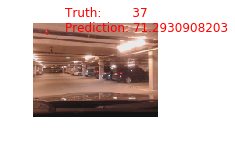

In [90]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(sample_images[i])


In [228]:
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (height, width))
                 for image in test_images]

In [231]:
# Run predictions against the full test set.
predicted = session.run([predicted_labels], 
                        feed_dict={images_ph: test_images32})[0]
print predicted
print test_labels
# Calculate how many matches we got.
match_count = sum([int(y == y_) for y, y_ in zip(test_labels, predicted)])
accuracy = match_count / len(test_labels)
print("Accuracy: {:.3f}".format(accuracy))

[22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 24 24 22 22 22 22
 22 22 22 22 22 22 22 22 22  0 22 22 22 22 22 22 22 24 24 24 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22  0  0  0 22 22 22
 22 22 22 22  0 22 22 22 22 22 22 22 22 22 22 24 24 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 24 22 22 22 22 22 22 22 22 22
 24 24 24 24 24 24 24 24 24 24 24 22 22 24 24 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 24 22
  0 22 22 22 22 22 22 24 22 22  0  0 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 24 22 22 22 22 24 24 24 24 22 24 22 22 22 22 22 24
 24 22 22 22 22 22  0  0 24 24 24 24 22 22 22 22 24 24 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22  0 24 24 24 24 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 22 22 22 22 24 24 24 24 24 24 22 22 22 22 24 24 24 24 24 22
 22 22  0 22

In [269]:
import input_data
import tensorflow as tf
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
x = tf.placeholder("float", shape=[None, 784])
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(x,W) + b)
y_ = tf.placeholder("float", shape=[None, 10])
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
# train data and get results for batches
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
# train the data
for i in range(10):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
print "accuracy", sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
prediction=tf.argmax(y,1)
print "predictions", prediction.eval(feed_dict={x: mnist.test.images}, session=sess)

ImportError: No module named input_data